In [ ]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  !nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [ ]:
%%capture
!pip install lightning
!pip install numpy

!pip install soundata
!pip install librosa
!pip install --no-cache-dir pytorch-lightning


In [ ]:
!pip install --no-cache-dir music-fsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 166.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 327.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 257.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 263.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 112.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 356.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 211.7 MB/s eta 0:00:00
  Created wheel for music-fsl: filename=music_fsl-0.1.6-py3-none-any.whl size=13036 sha256

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from typing import Tuple, Union
from collections import defaultdict

import numpy as np
import soundata
import random
import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy

import librosa

import music_fsl

from music_fsl.data import ClassConditionalDataset
import music_fsl.util as util
from music_fsl.util import widget

In [ ]:
from torchmetrics import Accuracy

In [ ]:
import lightning as L

In [ ]:
dataset = soundata.initialize('urbansound8k','/content/drive/MyDrive/UrbankSound8K')

In [ ]:
dataset.validate()

100%|██████████| 8732/8732 [1:05:30<00:00,  2.22it/s]


({'metadata': {}, 'clips': {}}, {'metadata': {}, 'clips': {}})

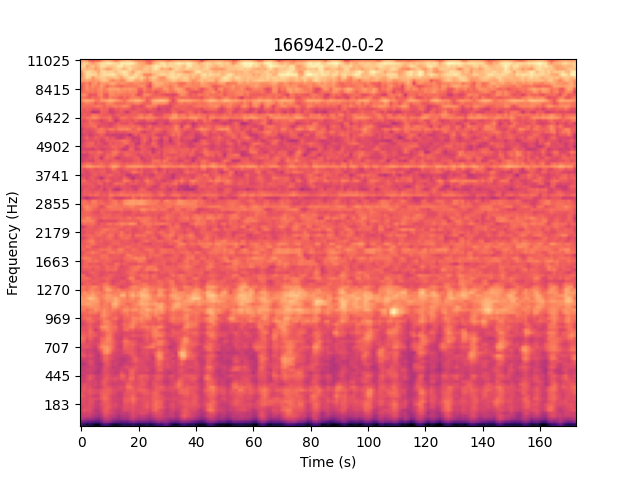

(None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:
example_track = dataset.choice_clip()
widget(example_track.audio_path)

In few-shot learning the data needs to be split classwise and in order to be able to do that we create a classconditional dataset which allows for use to easily access the data of the particular class in our dataset. Below is the code for the classconditional dataset where there is no overlap of classes between training data and test data.

In [ ]:
#The @property decorator is used to define a method as a "getter" for a class attribute. 
# When a user accesses the attribute, the method is automatically called to retrieve its value.

import torch
from typing import List, Dict, Any

class ClassConditionalDataset(torch.utils.data.Dataset):

    def __getitem__(self, index: int) -> Dict[Any, Any]:
        """
        Grab an item from the dataset. The item returned must be a dictionary. 
        """
        raise NotImplementedError
    
    @property
    def classlist(self) -> List[str]:
        """
        The classlist property returns a list of class labels available in the dataset.
        This property enables users of the dataset to easily access a list of all the classes in the dataset.

        Returns:
            List[str]: A list of class labels available in the dataset. 
        """
        raise NotImplementedError

    @property
    def class_to_indices(self) -> Dict[str, List[int]]:
        """
        Returns a dictionary where the keys are class labels and the values are 
        lists of indices in the dataset that belong to that class. 
        This property enables users of the dataset to easily access 
        examples that belong to specific classes. 

        Implement me!

        Returns:
            Dict[str, List[int]]: A dictionary mapping class labels to lists of dataset indices. 
        """
        raise NotImplementedError

Next, we inherit the classconditional dataset from the previous section and create a new class that loads the data.

In [ ]:
class urbansound8k(ClassConditionalDataset):
    """
    Initialize a `TinySOL` dataset instance.

    Args:
        instruments (List[str]): A list of instruments to include in the dataset.
        duration (float): The duration of each audio clip in the dataset (in seconds).
        sample_rate (int): The sample rate of the audio clips in the dataset (in Hz).
    """

    INSTRUMENTS = ['air_conditioner','car_horn','children_playing','dog_bark','drilling',
    'engine_idling','gun_shot','jackhammer','siren','street_music']

    def __init__(self, 
            instruments: List[str] = None,
            duration: float = 1.0, 
            sample_rate: int = 16000,
        ):
        # use all instruments if none are specified
        if instruments is None:
            instruments = self.INSTRUMENTS

        self.instruments = instruments
        self.duration = duration
        self.sample_rate = sample_rate

        # initialize the urbansound8k dataset and download if necessary
        self.dataset = soundata.initialize('urbansound8k','/content/drive/MyDrive/UrbankSound8K')
        self.dataset.validate()
        # self.dataset = dataset

        #make sure the instruments passed in are valid
        for instrument in instruments:
            assert instrument in self.INSTRUMENTS, f"{instrument} is not a valid instrument"

        # load all tracks for this instrument
        self.tracks = []
        for track in self.dataset.load_clips().values():
            total_duration = librosa.get_duration(filename=track.audio_path)
            if track.class_label in self.instruments and total_duration > 2.0:
                self.tracks.append(track)
        
    @property
    def classlist(self) -> List[str]:
        return self.instruments

    @property
    def class_to_indices(self) -> Dict[str, List[int]]:
        # cache it in self._class_to_indices 
        # so we don't have to recompute it every time
        if not hasattr(self, "_class_to_indices"):
            self._class_to_indices = defaultdict(list)
            for i, track in enumerate(self.tracks):
                self._class_to_indices[track.class_label].append(i)

        return self._class_to_indices

    def __getitem__(self, index) -> Dict:
        # load the track for this index
        track = self.tracks[index]

        # load the excerpt
        data = util.load_excerpt(track.audio_path, self.duration, self.sample_rate)
        data["label"] = track.class_label

        return data

    def __len__(self) -> int:
        return len(self.tracks)

The dataset is loaded and displayed to see the contents of the individual classes and examples per class.

In [ ]:
dataset = urbansound8k()

print(f"The dataset has {len(dataset)} examples.")
print(f"The dataset has {len(dataset.classlist)} classes.\n")

# print the number of examples for each class
for instrument, indices in dataset.class_to_indices.items():
    print(f"{instrument} has {len(indices)} examples")

100%|██████████| 8732/8732 [00:54<00:00, 160.79it/s]


The dataset has 7748 examples.
The dataset has 10 classes.

children_playing has 995 examples
air_conditioner has 1000 examples
jackhammer has 893 examples
drilling has 871 examples
engine_idling has 985 examples
dog_bark has 751 examples
siren has 904 examples
street_music has 1000 examples
gun_shot has 113 examples
car_horn has 236 examples


As the urbansound8k dataset has lot of examples for some classes we utilize this large number of examples per class and train in the same method that we can to evaluate it. Episodic training aims to split each training iteration into it’s own self-contained learning task. An episode is like a simulation of a few-shot learning scenario, typically with 
 classes and 
 labeled examples for each class – similar to what we expect the model to be able to infer at inference time.

In [ ]:
from typing import Tuple, Dict
class EpisodeDataset(torch.utils.data.Dataset):
    """
        A dataset for sampling few-shot learning tasks from a class-conditional dataset.

    Args:
        dataset (ClassConditionalDataset): The dataset to sample episodes from.
        n_way (int): The number of classes to sample per episode.
            Default: 5.
        n_support (int): The number of samples per class to use as support.
            Default: 5.
        n_query (int): The number of samples per class to use as query.
            Default: 20.
        n_episodes (int): The number of episodes to generate.
            Default: 100.
    """
    def __init__(self,
        dataset: ClassConditionalDataset, 
        n_way: int = 5, 
        n_support: int = 5,
        n_query: int = 20,
        n_episodes: int = 100,
    ):
        self.dataset = dataset

        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.n_episodes = n_episodes
    
    def __getitem__(self, index: int) -> Tuple[Dict, Dict]:
        """Sample an episode from the class-conditional dataset. 

        Each episode is a tuple of two dictionaries: a support set and a query set.
        The support set contains a set of samples from each of the classes in the
        episode, and the query set contains another set of samples from each of the
        classes. The class labels are added to each item in the support and query
        sets, and the list of classes is also included in each dictionary.

        Yields:
            Tuple[Dict[str, Any], Dict[str, Any]]: A tuple containing the support
            set and the query set for an episode.
        """
        # seed the random number generator so we can reproduce this episode
        rng = random.Random(index)

        # sample the list of classes for this episode
        episode_classlist = rng.sample(self.dataset.classlist, self.n_way)

        # sample the support and query sets for this episode
        support, query = [], []
        for c in episode_classlist:
            # grab the dataset indices for this class
            all_indices = self.dataset.class_to_indices[c]

            # sample the support and query sets for this class
            indices = rng.sample(all_indices, self.n_support + self.n_query)
            items = [self.dataset[i] for i in indices]

            # add the class label to each item
            for item in items:
                item["target"] = torch.tensor(episode_classlist.index(c))

            # split the support and query sets
            support.extend(items[:self.n_support])
            query.extend(items[self.n_support:])

        # collate the support and query sets
        support = util.collate_list_of_dicts(support)
        query = util.collate_list_of_dicts(query)

        support["classlist"] = episode_classlist
        query["classlist"] = episode_classlist
        
        return support, query

    def __len__(self):
        return self.n_episodes

    def print_episode(self, support, query):
        """Print a summary of the support and query sets for an episode.

        Args:
            support (Dict[str, Any]): The support set for an episode.
            query (Dict[str, Any]): The query set for an episode.
        """
        print("Support Set:")
        print(f"  Classlist: {support['classlist']}")
        print(f"  Audio Shape: {support['audio'].shape}")
        print(f"  Target Shape: {support['target'].shape}")
        print()
        print("Query Set:")
        print(f"  Classlist: {query['classlist']}")
        print(f"  Audio Shape: {query['audio'].shape}")
        print(f"  Target Shape: {query['target'].shape}")

Creating a Backbone Model
The first step in making our prototypical network is making a backbone model that can create embeddings from audio examples.

For the sake of simplicity, we’ll be using a fully convolutional model that takes in audio, computes a mel-spectrogram, and then applies a series of convolutional blocks to the spectrograms until it produces a 512-dimensional embedding.

In [ ]:
from torchaudio.transforms import MelSpectrogram
from torch import nn
import torch 

class ConvBlock(nn.Module):
    """
    A convolutional block, consisting of a convolution, group normalization,
    ReLU activation, and max pooling.
    """

    def __init__(self, 
        in_channels, out_channels, 
        kernel_size, stride, padding, 
        num_groups, max_pool_size
    ):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.gn = nn.GroupNorm(num_groups, out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(max_pool_size)

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x


class Backbone(nn.Module):
    """
    A fully convolutional model that produces 512-dimensional embeddings from audio samples. 
    
    Args:
        sample_rate (int): The sample rate of the input audio.
    """

    def __init__(self, sample_rate: int):
        super().__init__()
        self.melspec = MelSpectrogram(
            n_mels=64, sample_rate=sample_rate
        )
        
        self.conv1 = ConvBlock(1, 32, 3, 1, 'same', 8, 2)
        self.conv2 = ConvBlock(32, 64, 3, 1, 'same',16, 2)
        self.conv3 = ConvBlock(64, 128, 3, 1, 'same', 32, 2)
        self.conv4 = ConvBlock(128, 256, 3, 1, 'same', 64, 2)
        self.conv5 = ConvBlock(256, 512, 1, 1, 'same', 128, 4)

    def forward(self, x: torch.Tensor):
        assert x.ndim == 3, "Expected a batch of audio samples shape (batch, channels, samples)"
        assert x.shape[1] == 1, "Expected a mono audio signal"

        x = self.melspec(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # pool over the time dimension
        # squeeze the (t, f) dimensions
        x = x.mean(dim=-1) # computes the mean along the last dimension of x
        x = x.squeeze(-1).squeeze(-1) # (batch, 512) The code x.squeeze(-1).squeeze(-1) removes the last two dimensions of a tensor x if they have size 1.

        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Making a Prototypical Network

Let’s start by defining a new nn.Module. The backbone model is passed in as an argument to the constructor. We’ll be using this backbone model to compute the embeddings of the examples in the support and query sets.

In [ ]:
class PrototypicalNet(nn.Module):

    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone
    
    def forward(self, support: dict, query: dict):
        """
        Forward pass through the protonet. 

        Args:
            support (dict): A dictionary containing the support set. 
                The support set dict must contain the following keys:
                    - audio: A tensor of shape (n_support, n_channels, n_samples)
                    - label: A tensor of shape (n_support) with label indices
                    - classlist: A tensor of shape (n_classes) containing the list of classes in this episode
            query (dict): A dictionary containing the query set.
                The query set dict must contain the following keys:
                    - audio: A tensor of shape (n_query, n_channels, n_samples)
        
        Returns:
            logits (torch.Tensor): A tensor of shape (n_query, n_classes) containing the logits

        After the forward pass, the support dict is updated with the following keys:
            - embeddings: A tensor of shape (n_support, n_features) containing the embeddings
            - prototypes: A tensor of shape (n_classes, n_features) containing the prototypes
        
        The query dict is updated with
            - embeddings: A tensor of shape (n_query, n_features) containing the embeddings

        """
        # compute the embeddings for the support and query sets
        support["embeddings"] = self.backbone(support["audio"])
        query["embeddings"] = self.backbone(query["audio"])

        # group the support embeddings by class
        support_embeddings = []
        for idx in range(len(support["classlist"])):
            embeddings = support["embeddings"][support["target"] == idx]
            support_embeddings.append(embeddings)
        support_embeddings = torch.stack(support_embeddings)

        # compute the prototypes for each class
        prototypes = support_embeddings.mean(dim=1)
        support["prototypes"] = prototypes

        #compute the distances between each query and prototype
        distances = torch.cdist(
            query["embeddings"].unsqueeze(0), 
            prototypes.unsqueeze(0),
            p=2
        ).squeeze(0)

        # square the distances to get the sq euclidean distance
        distances = distances ** 2
        logits = -distances

        # return the logits
        return logits

In [ ]:
%%capture
sample_rate = 16000
from music_fsl.data import EpisodeDataset


# create an episodic dataset
episodes = EpisodeDataset(
    dataset,
    n_way=5, 
    n_support=5,
    n_query=20,
    n_episodes=100,
)

support, query = episodes[0]
episodes.print_episode(support, query)

In [ ]:
backbone = Backbone(sample_rate)
print(backbone)
# create a prototypical net
protonet = PrototypicalNet(backbone)

Backbone(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (conv1): ConvBlock(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (gn): GroupNorm(8, 32, eps=1e-05, affine=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (gn): GroupNorm(16, 64, eps=1e-05, affine=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (gn): GroupNorm(32, 128, eps=1e-05, affine=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (gn

In [ ]:
# compute the logits for the sample episode
logits = protonet(support, query)
print(f"got logits with shape {logits.shape}")

got logits with shape torch.Size([100, 5])


Few-shot learning model for music information retrieval using pytorch lightning library

In [ ]:
sample_rate = 16000 # sample rate of the audio
n_way= 3 # number of classes per episode
n_support = 5 # number of support examples per class
n_query = 20 # number of samples per class to use as query
n_train_episodes = 250 # number of episodes to generate for training
n_val_episodes = 10 # number of episodes to generate for validation
num_workers = 2# number of workers to use for data loading

In [ ]:
TRAIN_INSTRUMENTS = ['air_conditioner','children_playing','dog_bark','drilling',
'engine_idling','gun_shot','siren']
 
TEST_INSTRUMENTS = ['car_horn','street_music','jackhammer']

In [ ]:
# initialize the datasets
train_data = urbansound8k(
    instruments=TRAIN_INSTRUMENTS, 
    sample_rate=sample_rate
)

val_data = urbansound8k(
    instruments=TEST_INSTRUMENTS, 
    sample_rate=sample_rate
)

100%|██████████| 8732/8732 [00:57<00:00, 152.16it/s]


In [ ]:
# initialize the episode datasets
train_episodes = EpisodeDataset(
    dataset=train_data, 
    n_way=n_way, 
    n_support=n_support,
    n_query=n_query, 
    n_episodes=n_train_episodes
)

val_episodes = EpisodeDataset(
    dataset=val_data, 
    n_way=n_way, 
    n_support=n_support,
    n_query=n_query, 
    n_episodes=n_val_episodes
)

In [ ]:
# initialize the dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_episodes, 
    batch_size=None,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_episodes, 
    batch_size=None,
    num_workers=num_workers
)

In [ ]:
import lightning as L

In the FewShotLearner class, we’ll define a step method that performs the actual training step. This method takes in a batch of data, the batch index, and a string tag that indicates whether the step is for training, validation, or testing.


The step method is where the majority of the logic for training the model resides. It is here that we make predictions with the PrototypicalNet, compute the loss and evaluation metrics, and log the output. By defining a separate step method, we can easily reuse this logic for the training, validation, and testing steps.

In [ ]:
class FewShotLearner(L.LightningModule):

    def __init__(self, 
        protonet: nn.Module, 
        learning_rate: float = 1e-3,
        num_classes: int = 2
    ):
        super().__init__()
        self.save_hyperparameters(ignore=['protonet'])
        self.protonet = protonet
        self.learning_rate = learning_rate

        self.loss = nn.CrossEntropyLoss()
        self.metrics = nn.ModuleDict({
            'accuracy': Accuracy(task='multiclass',num_classes = num_classes, top_k = 2)
        })

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def step(self, batch, batch_idx, tag: str):
        support, query = batch

        logits = self.protonet(support, query)
        loss = self.loss(logits, query["target"])

        output = {"loss": loss}
        for k, metric in self.metrics.items():
            output[k] = metric(logits, query["target"])

        for k, v in output.items():
            self.log(f"{k}/{tag}", v)
        return output

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "test")

In [ ]:
learner = FewShotLearner(protonet = protonet, num_classes = n_way)
print(learner)

FewShotLearner(
  (protonet): PrototypicalNet(
    (backbone): Backbone(
      (melspec): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (conv1): ConvBlock(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (gn): GroupNorm(8, 32, eps=1e-05, affine=True)
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (gn): GroupNorm(16, 64, eps=1e-05, affine=True)
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (gn): GroupNorm(32, 128, eps=1e-05, affine=True)
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padd

In [ ]:
# set up the trainer

from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.profilers import SimpleProfiler

tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=".",
        name="logs"
    )

profiler = SimpleProfiler(filename="profile.txt")

trainer = L.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else 0,
    max_epochs=1,
    log_every_n_steps=1, 
    val_check_interval=50,
    profiler=profiler, 
    logger=tb_logger, 
)

# train!
trainer.fit(learner, train_loader, val_dataloaders=val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type             | Params
----------------------------------------------
0 | protonet | PrototypicalNet  | 521 K 
1 | loss     | CrossEntropyLoss | 0     
2 | metrics  | ModuleDict       | 0     
----------------------------------------------
521 K     Trainable params
0         Non-trainable params
521 K     Total params
2.086     Total estimat

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


# New section

In [ ]:
# from pathlib import Path
# from music_fsl.protonet import PrototypicalNet
# from music_fsl.backbone import Backbone
# from music_fsl.train import FewShotLearner, TEST_INSTRUMENTS
from music_fsl.util import dim_reduce, embedding_plot, batch_device
# from music_fsl.data import EpisodeDataset

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_rate = 16000

In [ ]:
protonet = PrototypicalNet(Backbone(sample_rate))
learner = FewShotLearner(protonet)
learner.eval()
learner = learner.to(DEVICE)

In [ ]:
n_way = 3
n_support = 5
n_query = 20
n_episodes = 10

# load our evaluation data
test_episodes = EpisodeDataset(
    dataset= val_data, 
    n_way=n_way, 
    n_support=n_support,
    n_query=n_query, 
    n_episodes=n_episodes
)

In [ ]:
# instantiate the accuracy metric
metric = Accuracy(task='multiclass', num_classes=n_way, top_k = 2).to(DEVICE)

In [ ]:
# collect all the embeddings in the test set
# so we can plot them later
import tqdm
embedding_table = []
pbar = tqdm.tqdm(range(len(test_episodes)))
for episode_idx in pbar:
    support, query = test_episodes[episode_idx]

    # move all tensors to cuda if necessary
    batch_device(support, DEVICE)
    batch_device(query, DEVICE)

    # get the embeddings
    logits = learner.protonet(support, query)

    # compute the accuracy
    acc = metric(logits, query["target"])
    pbar.set_description(f"Episode {episode_idx} // Accuracy: {acc.item():.2f}")

    # add all the support and query embeddings to our records
    for subset_idx, subset in enumerate((support, query)):
        for emb, label in zip(subset["embeddings"], subset["target"]):
            embedding_table.append({
                "embedding": emb.detach().cpu().numpy(),
                "label": support["classlist"][label],
                "marker": ("support", "query")[subset_idx], 
                "episode_idx": episode_idx
            })
        
    # also add the prototype embeddings to our records
    for class_idx, emb in enumerate(support["prototypes"]):
        embedding_table.append({
            "embedding": emb.detach().cpu().numpy(),
            "label": support["classlist"][class_idx],
            "marker": "prototype", 
            "episode_idx": episode_idx
        })



Episode 9 // Accuracy: 0.75: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


In [ ]:
# compute the total accuracy across all episodes
total_acc = metric.compute()
print(f"Total accuracy, averaged across all episodes: {total_acc:.2f}")

Total accuracy, averaged across all episodes: 0.79


In [ ]:
def dim_reduce(
        embeddings: np.ndarray, 
        n_components: int = 3,
        method: str= 'umap',
    ):
    """
    This function performs dimensionality reduction on a given set of embeddings. 
    It can use either UMAP, t-SNE, or PCA for this purpose. The number of components 
    to reduce the data to and the method used for reduction can be specified as arguments. 
    It returns the projected embeddings as a NumPy array.

    Args:
        embeddings (np.ndarray): An array of embeddings, with shape (n_samples, n_features)
        n_components (int): The number of dimensions to reduce the embeddings to. Default: 3
        method (str): The method of dimensionality reduction to use.
                        One of 'umap', 'tsne', or 'pca'. Default: 'umap'

    Returns:
        proj (np.ndarray): The dimensionality-reduced embeddings, with shape (n_samples, n_components)
    """

    if method == 'umap':
        import umap
        reducer = umap.UMAP(
            n_neighbors=5, 
            n_components=n_components, 
            metric='euclidean'
        )
    elif method == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(
            n_components=n_components, 
            init='pca', 
            learning_rate='auto'
        )
    
    elif method == 'pca':
        from sklearn.decomposition import PCA
        reducer =  PCA(n_components=n_components)
    else:
        raise ValueError(f'dunno how to do {method}')
 
    proj = reducer.fit_transform(embeddings)

    return proj

In [ ]:
def embedding_plot(
        proj: np.ndarray, 
        color_labels: List[Union[int, str]], 
        marker_labels: List[int] = None,
        title: str = ''
    ):
    """
    Plot a set of embeddings that have been reduced using dim_reduce.

    Args:
        proj: a numpy array of shape (n_samples, n_components)
        color_labels: a list of labels to color the points by
        marker_labels: a list of labels to use as markers
        title: the title of the plot

    Returns:
        a plotly figure object
    """
    import plotly.express as px
    import pandas as pd
    
    n_components = proj.shape[-1]
    if n_components == 2:
        df = pd.DataFrame(dict(
            x=proj[:, 0],
            y=proj[:, 1],
            label=color_labels
        ))
        fig = px.scatter(
            df, x='x', y='y', 
            color='label',
            title=title, 
            symbol=marker_labels
        )
    elif n_components == 3:
        df = pd.DataFrame(dict(
            x=proj[:, 0],
            y=proj[:, 1],
            z=proj[:, 2],
            label=color_labels
        ))
        fig = px.scatter_3d(
            df, x='x', y='y', z='z',
            color='label',
            symbol=marker_labels,
            title=title
        )
    else:
        raise ValueError(f"can only plot 2 or 3 components but got {n_components}")

    fig.update_traces(marker=dict(size=6,
                                  line=dict(width=1,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))

    return fig

In [ ]:
# perform a TSNE over all embeddings in the test dataset
embeddings = dim_reduce(
    embeddings=np.stack([d["embedding"] for d in embedding_table]),
    method="tsne",
    n_components=2,
)
for entry, dim_reduced_embedding in zip(embedding_table, embeddings):
    entry["embedding"] = dim_reduced_embedding

fig = embedding_plot(
    proj=np.stack([d["embedding"] for d in embedding_table]),
    color_labels=[d["label"] for d in embedding_table],
    marker_labels=[d["marker"] for d in embedding_table],
    title="urbansound8k Protonet Embeddings")

fig.show()

In [ ]:
episode_idx = 5

subtable = [d for d in embedding_table if d["episode_idx"] == episode_idx]

fig = embedding_plot(
    proj=np.stack([d["embedding"] for d in subtable]),
    color_labels=[d["label"] for d in subtable],
    marker_labels=[d["marker"] for d in subtable],
    title=f"episode {episode_idx} -- embeddings",
)
fig.show()